In [34]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split

In [35]:
data = pd.read_csv('downsampled_data.csv')

In [36]:
# Filter the dataset to include only the specified features
selected_features = [
     'SYNOPCode',
 'Visibility',
 'Temperature',
 'AbsoluteHumidityMin',
 'ParticulateMax',
 'RainIntensityMax',
 'Distance',
 'RainIntensity',
 'RainIntensityMin',
    'RFL_Att',
 'AbsoluteHumidity']

filtered_data = data[selected_features]

In [37]:
# Separate predictors and target variable (RFL_Att)
X = filtered_data.drop(columns=['RFL_Att'])  # Predictors
y = filtered_data['RFL_Att']  # Target variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],  # Number of trees
    'max_depth': [10, 20, None],     # Maximum depth of each tree
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],   # Minimum number of samples required at each leaf node
}

# Initialize and train the model
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1)


# Perform grid search
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the tuned model
predictions = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [38]:
# Assuming `predictions` is a NumPy array
predictions = np.array(predictions)  # Replace with your actual predictions array

# Convert to DataFrame
predictions_df = pd.DataFrame(predictions, columns=['Predicted_RF'])  # Name the column appropriately

# Save to CSV
predictions_df.to_csv('Results/Gen_pred_RF.csv', index=False)

In [7]:
# Print the results
print("Best Parameters from GridSearchCV:", best_params)
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

Best Parameters from GridSearchCV: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
RMSE: 1.012864212475138
R^2: 0.9276946080442825


In [8]:

# Initialize a dictionary to store results for each weather condition 
results = {} 
# Loop through unique SYNOP codes (weather conditions)
for synop in X_test['SYNOPCode'].unique(): 
    # Filter test data for the current SYNOP code 
    X_test_synop = X_test[X_test['SYNOPCode'] == synop]
    y_test_synop = y_test[X_test.index.isin(X_test_synop.index)] 
    
    # Make predictions for this subset 
    predictions = best_model.predict(X_test_synop) 
    
    # Calculate RMSE and R² for this subset 
    rmse = np.sqrt(mean_squared_error(y_test_synop, predictions)) 
    r2 = r2_score(y_test_synop, predictions) 
    
    # Store results 
    results[synop] = {'RMSE': rmse, 'R²': r2}
    
# Convert results to a DataFrame for easier visualization
results_df = pd.DataFrame.from_dict(results, orient='index').reset_index() 
results_df.columns = ['SYNOP', 'RMSE', 'R²']

print("Weather Condition Evaluation Results:")
print(results_df)

Weather Condition Evaluation Results:
   SYNOP      RMSE        R²
0      6  1.540557  0.917156
1      0  0.801069  0.919696
2      5  0.769868  0.931623
3      8  1.056519  0.888754
4      4  0.396706  0.930485
5      7  0.436397  0.921501
6      3  0.441821  0.977458


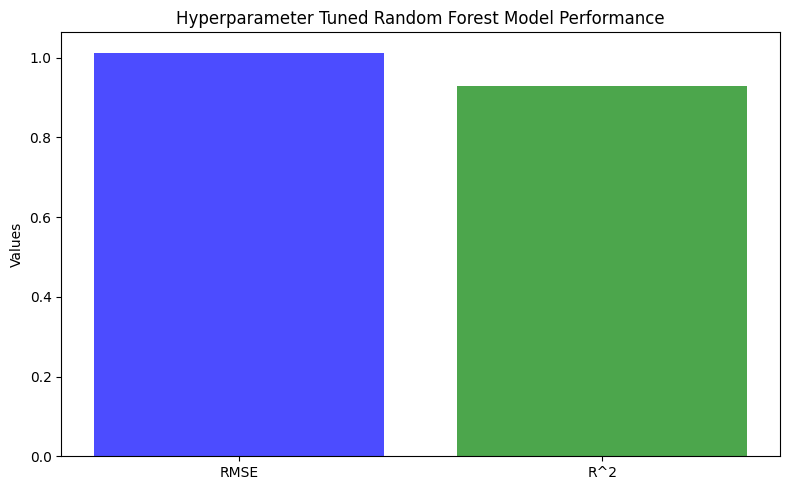

In [39]:
# Visualization of RMSE and R^2
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(['RMSE', 'R^2'], [rmse, r2], color=['blue', 'green'], alpha=0.7)
plt.title("Hyperparameter Tuned Random Forest Model Performance")
plt.ylabel("Values")
plt.tight_layout()
plt.show()

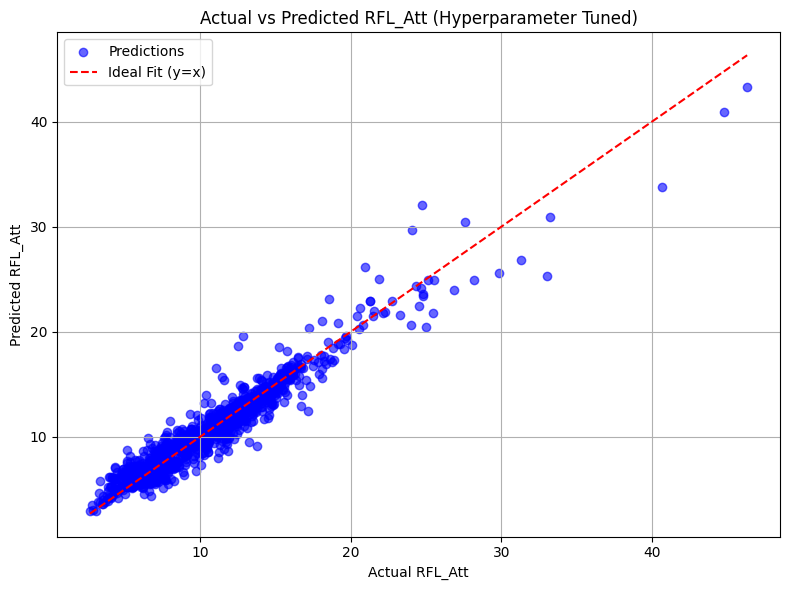

In [28]:
# Scatter plot of actual vs predicted values with a diagonal line
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.6, color="blue", label="Predictions")

# Add diagonal line
max_val = max(max(y_test), max(predictions))  # Find the max value to set the diagonal range
min_val = min(min(y_test), min(predictions))  # Find the min value to set the diagonal range
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="Ideal Fit (y=x)")

# Labels, title, and legend
plt.xlabel("Actual RFL_Att")
plt.ylabel("Predicted RFL_Att")
plt.title("Actual vs Predicted RFL_Att (Hyperparameter Tuned)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

Insights from the Model Performance:
Strong Fit for Most Data:

The clustering around the diagonal shows that the model performs well for a majority of the observations.
The hyperparameter tuning likely improved the model's accuracy.
Slight Difficulty with High Values:

Predictions deviate more for higher values of RFL_Att (e.g., 25+).
This could suggest the need for:
More training data for extreme values.
Alternative models that handle extreme values better, such as Gradient Boosting.
Generalizable Model:

The graph shows the model is reasonably robust and not overfitting, as most predictions align well with actual values.